# **DA5401: Assignment 8**
*Ensemble Learning for Complex Regression Modeling on Bike Share Data*

**Problem Statement:**

Utilise the three primary ensembling techniques (Bagging, Boosting and Stacking) to solve a time-series based regression problem, addressing how the models address bias and variance, and how diverse stacks might yeild superior performance. The dataset used is the **Bike Sharing Demand Dataset (Hourly Data)** by *Fanaee-T, Hadi, and Gamper, H. (2014). Bikeshare Data Set. UCI Machine Learning Repository.* The task involves predicting the total count of the rented bikes.

The dataset can be downloaded from the following link: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset



Author: **Devashish Tripathi**

Roll No. **DA25C006**

**Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, SplineTransformer, StandardScaler
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
random_state= 42
colors = sns.color_palette('colorblind', 30)
tscv = TimeSeriesSplit(n_splits= 3) # since data is timeseries, so instead of standard cv in grid, need to use this method

Helper Function for Grid Search

In [ ]:
def grid_search(model, params, X_train, y_train, cv= 3, refit= True, n_jobs= -1, verbose= 0):
    grid = GridSearchCV(model, params, scoring= 'neg_root_mean_squared_error', cv= cv, refit= refit, n_jobs= n_jobs, verbose= verbose)
    grid.fit(X_train, y_train)
    print('Best Params:', grid.best_params_)
    print('Best Score:', -grid.best_score_)

    return grid

# Tasks

## Part A: Data Preprocessing and Baseline

### Data Loading and Feature Engineering

**Loading the file**

In [ ]:
df = pd.read_csv('hour.csv')
display(df.head())
print('Shape:', df.shape)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Shape: (17379, 17)


**Description of the dataframe**

In [ ]:
print("NaN values:", df.isna().sum())

NaN values: instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [ ]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Visualising the hourly demand of cycles in a week

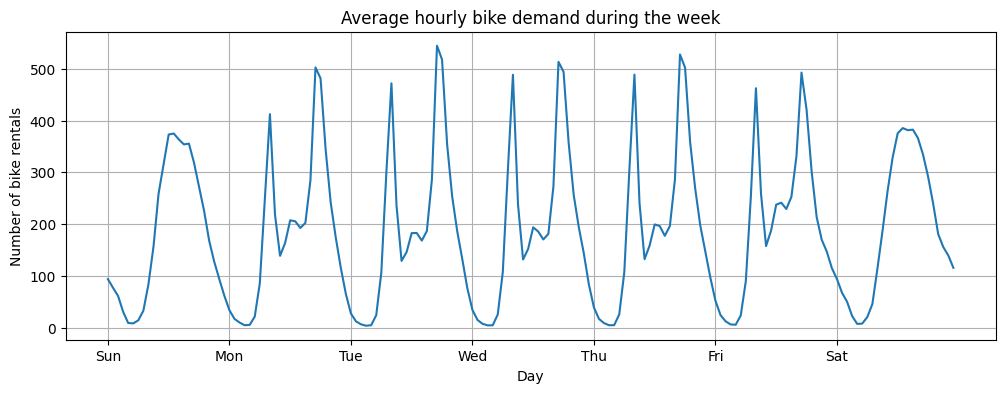

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hr"])["cnt"].mean()
average_week_demand.plot(ax=ax)
plt.grid(True)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Day",
    ylabel="Number of bike rentals",
)

*It becomes apparent that the bikes are used for leisure on weekends and for commute to office on weekdays, with the weekdays following one pattern and the weekends following another pattern, showcasing the data is periodic*

**Dropping irrelevant variables**

{such as instant of rental (just indexing), date of rental (already specified through other variables) and user type (is added to give cnt, the var to be predicted)}

In [ ]:
X, y = df.drop('cnt', axis= 1), df['cnt']
X = X.drop(['instant', 'dteday', 'casual', 'registered'], axis= 1)
print('Shape after dropping:', X.shape)

Shape after dropping: (17379, 12)


**Categorical -> Numerical**

As the Readme.txt file provided along with the dataset describes the variables as follows: mnth is from 1-12, hr is from 0-23, weekday is from 1-7, season and weathersit are each from 1-4. As mnth, hr and weekday are periodic in order (shown above), OHE won't capture this and would introduce sparsity. season can be encoded in ohe, as it won't introduce too much sparsity and possess values only from 1-4. As weather can change per-day, it has no cyclical information and thus can be safely encoded via OHE

In [ ]:
periodic_vars = ['hr', 'weekday', 'mnth']
ohe_vars = ['season', 'weathersit']

Visualising count of the categoricals

In [ ]:
season_map = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
weathersit_map = {1: 'Clear', 2: 'Mist', 3: 'Rain', 4: 'Heavy Rain'}
weekday_map = {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'}
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
hour_map = {i: f'{i}' for i in range(24)}

name_map = {'hr': 'Hour', 'weekday': 'Weekday', 'mnth': 'Month',
           'season': 'Season', 'weathersit': 'Weather'}
map_map = {'hr': hour_map, 'weekday': weekday_map, 'mnth': month_map,
           'season': season_map, 'weathersit': weathersit_map}

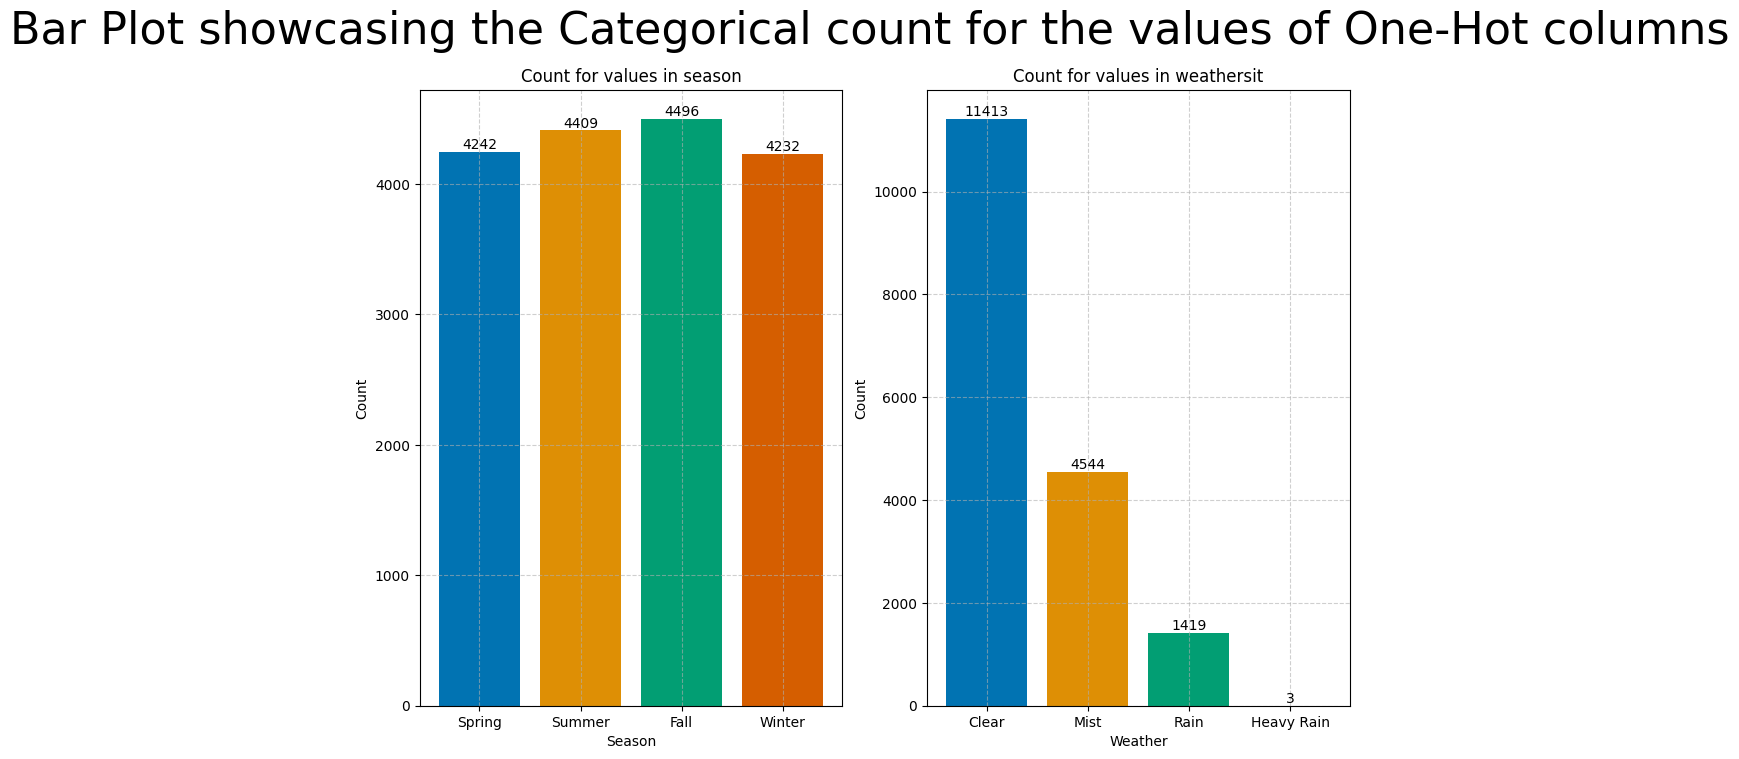

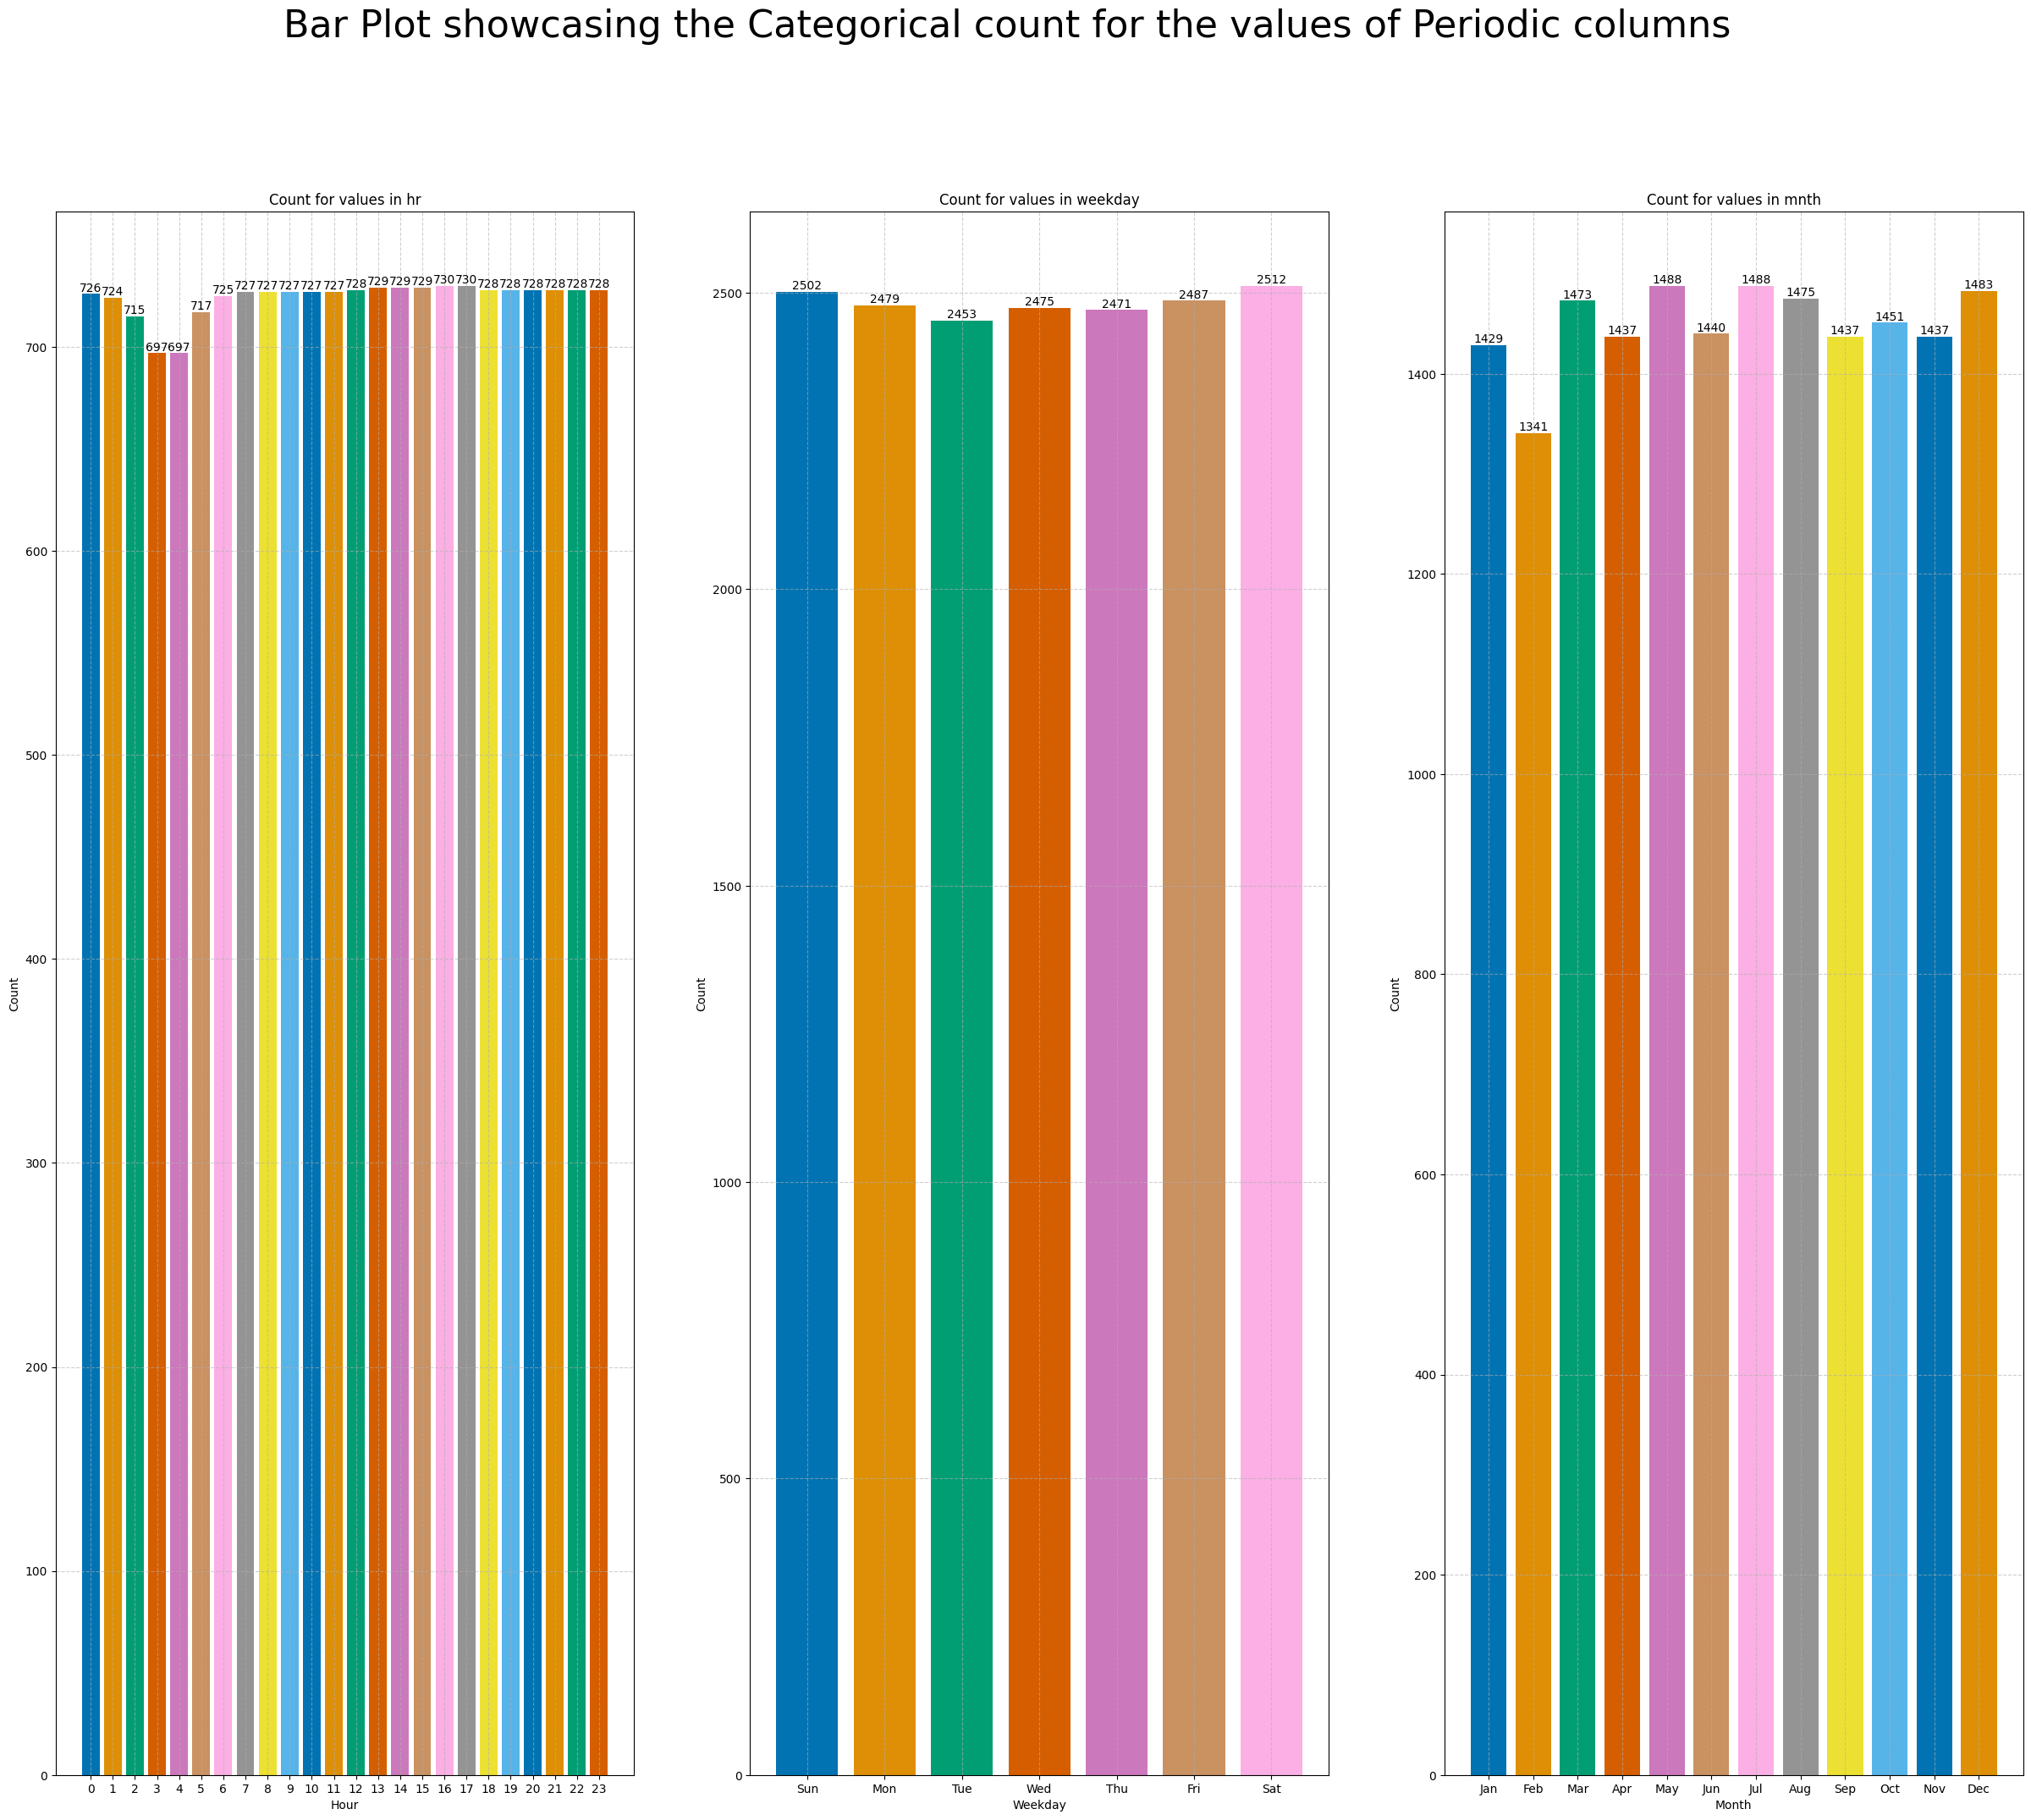

In [ ]:
for k, ls in {'ohe': ohe_vars, 'per': periodic_vars}.items():
    title_key = 'One-Hot' if k == 'ohe' else 'Periodic'
    figsize = (12, 8) if k == 'ohe' else (30, 24)

    fig, ax = plt.subplots(1, len(ls), figsize = figsize)
    for idx, var in enumerate(ls):

        vcounts = X[var].value_counts().sort_index()
        xaxis = range(1, len(vcounts)+1) if var != 'hr' else range(len(vcounts))
        bars = ax[idx].bar(xaxis, list(vcounts), color= colors)
        ax[idx].bar_label(bars)
        ax[idx].set_title(f'Count for values in {var}')
        ax[idx].set_xticks(list(map_map[var].keys()))
        ax[idx].set_xticklabels(map_map[var].values())
        ax[idx].grid(True, alpha= 0.6, linestyle= '--')
        ax[idx].set_xlabel(name_map[var])
        ax[idx].set_ylabel('Count')

    plt.suptitle(f'Bar Plot showcasing the Categorical count for the values of {title_key} columns', fontsize= 32)
    plt.show()
    print('\n\n\n\n')

*With the exception of 'Heavy Rain' in 'weathersit', every other variable is well distributed. As such, while encoding, it can be merged with the 'Rain' column*

In [ ]:
X['weathersit'] = (X['weathersit'].astype(object).
                   replace(to_replace= 4, value= 3).astype('category'))
X['weathersit'].value_counts()

/tmp/ipython-input-4255112300.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  replace(to_replace= 4, value= 3).astype('category'))


,count
weathersit,
1,11413
2,4544
3,1422


OHE columns

In [ ]:
ohe_obj = OneHotEncoder(sparse_output= False)
new_ohe = ohe_obj.fit_transform(X[ohe_vars])
ohe_names = ohe_obj.get_feature_names_out()

X = X.drop(ohe_vars, axis= 1)
X[ohe_names] = new_ohe

Periodic Columns

*Mathematically speaking, splines are smooth curves madeof piecewise polynomials. As such, these allow for gradual change from one value to another and are suited well for periodic values, such as time and weekday, especially when the start and the end points are close to each other (23 hours leads to 0 hours). By having 'half' the number of splines as the period, a balance between representation and sparsity is maintained.*

In [ ]:
def periodic_spline_transformer(period, n_splines):
    n_knots = n_splines + 1
    return SplineTransformer(
        n_knots= n_knots,
        knots = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation= "periodic",
        include_bias= True
    )

def assign_pstcols(df, cols, name):
    for idx in range(cols.shape[1]):
        df[f'{name}_{idx}'] = cols[:, idx]

In [ ]:
cyclic_hr = periodic_spline_transformer(24, n_splines= 12).fit_transform(X[['hr']])
cyclic_weekday = periodic_spline_transformer(7, n_splines= 3).fit_transform(X[['weekday']])
cyclic_mnth = periodic_spline_transformer(12, n_splines= 6).fit_transform(X[['mnth']])

assign_pstcols(X, cyclic_hr, 'cyclic_hr')
assign_pstcols(X, cyclic_weekday, 'cyclic_weekday')
assign_pstcols(X, cyclic_mnth, 'cyclic_mnth')

X = X.drop(periodic_vars, axis= 1)

In [ ]:
print('Shape after encoding:', X.shape)
X.columns

Shape after encoding: (17379, 35)


Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_1', 'season_2', 'season_3', 'season_4', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'cyclic_hr_0', 'cyclic_hr_1',
       'cyclic_hr_2', 'cyclic_hr_3', 'cyclic_hr_4', 'cyclic_hr_5',
       'cyclic_hr_6', 'cyclic_hr_7', 'cyclic_hr_8', 'cyclic_hr_9',
       'cyclic_hr_10', 'cyclic_hr_11', 'cyclic_weekday_0', 'cyclic_weekday_1',
       'cyclic_weekday_2', 'cyclic_mnth_0', 'cyclic_mnth_1', 'cyclic_mnth_2',
       'cyclic_mnth_3', 'cyclic_mnth_4', 'cyclic_mnth_5'],
      dtype='object')

In [ ]:
X.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_1,season_2,season_3,...,cyclic_hr_11,cyclic_weekday_0,cyclic_weekday_1,cyclic_weekday_2,cyclic_mnth_0,cyclic_mnth_1,cyclic_mnth_2,cyclic_mnth_3,cyclic_mnth_4,cyclic_mnth_5
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,0.028770,0.682721,0.496987,0.475775,0.627229,0.190098,0.244088,0.253697,0.258703,...,0.083782,0.333597,0.334547,0.331856,0.166766,0.166173,0.162964,0.166930,0.168707,0.168460
std,0.500008,0.167165,0.465431,0.192556,0.171850,0.192930,0.122340,0.429557,0.435139,0.437935,...,0.182207,0.220711,0.221209,0.220851,0.228188,0.229596,0.225432,0.229180,0.228935,0.229527
min,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.044218,0.064626,0.044218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,0.000000,0.000000,0.000000,...,0.000000,0.105442,0.064626,0.105442,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.500000,0.484800,0.630000,0.194000,0.000000,0.000000,0.000000,...,0.000000,0.338678,0.246842,0.338678,0.020833,0.020833,0.020833,0.020833,0.020833,0.020833
75%,1.000000,0.000000,1.000000,0.660000,0.621200,0.780000,0.253700,0.000000,1.000000,1.000000,...,0.020833,0.596696,0.522352,0.596696,0.166667,0.479167,0.166667,0.479167,0.479167,0.479167
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,1.000000,1.000000,1.000000,...,0.666667,0.647716,0.666667,0.647716,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667


*Variables are in different scales, which could cause an issue for distance-based models such as KNR and Ridge, while it won't cause significant effect to tree-based models. As such, it is better to apply scaling AFTER splitting the dataset. Speaking of...*

### Train-Test Split

Since it is a time-series data, where forecasting is the primary task, it is better to keep test data values from the future. As the dataset is already sorted in order from old to new, we can just take the bottom 20% rows for training

In [ ]:
n_samples = X.shape[0]
ratio = int(n_samples * 0.8)
X_train, y_train, X_test, y_test = X[:ratio], y[:ratio], X[ratio:], y[ratio:]

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Baseline Model

Defining the grid search space

In [ ]:
dtree_model = DecisionTreeRegressor(max_depth= 6, random_state= random_state)
dtree_params = {
    'criterion': ['squared_error', 'friedman_mse'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0., 0.5, 1]
}
lreg_model = LinearRegression()

In [ ]:
print('Grid Searching for DecisionTree and Refitting...')
best_dtree = grid_search(dtree_model, dtree_params, X_train, y_train, cv= tscv, verbose= 1, n_jobs= 1)
print('Done')
print('Fitting Linear Regression')
lreg_model.fit(X_train, y_train)
print('Done')

Grid Searching for DecisionTree and Refitting...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Params: {'ccp_alpha': 0.5, 'criterion': 'squared_error', 'max_features': None, 'splitter': 'best'}
Best Score: 105.71129697384158
Done
Fitting Linear Regression
Done


Comparison on RMSE

In [ ]:
dtree_rmse = root_mean_squared_error(y_true= y_test, y_pred= best_dtree.predict(X_test))
lreg_rmse = root_mean_squared_error(y_true= y_test, y_pred= lreg_model.predict(X_test))

print(f'RMSE:: LinReg: {lreg_rmse:.3f} :: DTree: {dtree_rmse:.3f}')

RMSE:: LinReg: 135.970 :: DTree: 128.377


*Linear Regression has a test-RMSE of 135.97, while Decision Tree has an RMSE of 128.38. While both are poor, Decision Tree outperforms Linear Regression. A reason for this could be the non-linearity of the dataset being better modelled by the Decision Tree as compared to the linear Linear Regression.*

As such, the baseline model is **Decision Tree**

In [ ]:
baseline = DecisionTreeRegressor(max_depth= 6, random_state= random_state, ccp_alpha= 0.5, criterion= 'squared_error', max_features= None, splitter= 'best')
baseline.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.5, max_depth=6, random_state=42)

## Part B: Ensemble Techniques for Bias and Variance Reduction

### Bagging (Variance Reduction)

**Hypothesis: Bagging Primarily targets Variance Reduction**

*Bagging works by taking multiple independent base models and training them on different subsets of the training data, where the subsets are generated with replacement, ensuring each bag is independent from the others, as the sample chosen does not depend on the previous one. The models are fitted and averaging of the output is done for a given input to get a final output.*

*As the individual models are trained on different subsets of the dataset, they tend to overfit on their respective subsets, which means that while aggregating the results, empirical evidence has shown that these variances are cancelled out by each other, leading to a decrease in variance. As the general base estimator is taken to be decision trees, which are generally low-bias, this leads to an overall decrease in variance.*

#### Bagging Regressor Implementation

Grid Implementation

In [ ]:
# bag_params = {
#     'n_estimators': [50, 100, 200, 500],
#     'max_samples': [1.0, 0.75, 0.5, 0.25],
#     'max_features': [1.0, 0.75, 0.5, 0.25],
#     'oob_score': [True, False],
#     'warm_start': [True, False],
#     'bootstrap_features': [True, False]
# }

# estimator = DecisionTreeRegressor(max_depth= 6, random_state= random_state, ccp_alpha= 0.0, criterion= 'squared_error', max_features= None, splitter= 'best')
# print('Grid Search on Bagging Regressor')
# bag_model = BaggingRegressor(estimator= estimator, random_state= random_state, n_jobs= -1)
# best_bag = grid_search(bag_model, bag_params, X_train, y_train, cv= tscv, verbose= 2, n_jobs= 1)

In [ ]:
estimator = DecisionTreeRegressor(max_depth= 6, random_state= random_state, ccp_alpha= 0.0, criterion= 'squared_error', max_features= None, splitter= 'best')
bag_model = BaggingRegressor(estimator= estimator, random_state= random_state, n_jobs= -1, bootstrap_features= True, n_estimators= 50, oob_score= True, warm_start= False)
bag_model.fit(X_train, y_train)
bag_rmse = root_mean_squared_error(y_true= y_test, y_pred= bag_model.predict(X_test))
print(f'Bagging RMSE: {bag_rmse:.3f}')

Bagging RMSE: 121.893


####
**Did the bagging technique reduce the variance? Compare it with the baseline Decision Tree Model**

*Yes, Bagging was responsible for decreasing the variance, as compared to the baseline Decision Tree. Bagging RMSE was 121.893, while that of the Decision Tree was 128.377. While not a very siginificant decrease, this indicates two crucial things:*

*1. The decision trees, which are generally low-bias models due to no assumptions made about the data mean combining many overfit decision trees and averaging them was going to decrease the variance by cancelling out the errors.*

*2. As decision trees are generally low-bias model, no significant decrease in the RMSE indicates that the dataset has inherent bias in it, which propagated to the bags. This might be due to the fact that bike usage might be higher on certain holidays such as weekends.*

### Boosting (Bias Reduction)

**Hypothesis: Boosting primarily targets Bias Reduction**

*Boosting focuses on weak-learner models, initially starting with a weak-learner (a model which performs some threshold better than random prediction) and weighing each train point equally. Each model focuses on correcting the previous model's errors, by placing higher weights on points with higher errors for the previous model, thus focusing on harder examples. Thus, by constantly focusing on the areas where the model is underfitting, the model is able to reduce the bias, which might be due to model or even inherent to the dataset*

Implementation

In [ ]:
# # Takes around 2.5 hours.

# boost_params = {
#     'learning_rate': [0.1, 0.01, 1],
#     'n_estimators': [100, 200, 500, 1000],
#     'max_depth': [1, 3, None],
#     'subsample': [1.0, 0.75, 0.5, 0.25],
#     'max_features': ['sqrt', 'log2', None],
#     'warm_start': [True, False]
# }

# best_boost = grid_search(GradientBoostingRegressor(random_state= random_state), boost_params, X_train, y_train, cv= tscv, verbose= 2, n_jobs= 1)

In [ ]:
boost_model = GradientBoostingRegressor(random_state= random_state, learning_rate= 0.1, max_depth= 3, max_features= None, n_estimators= 1000, subsample= 0.5, warm_start= True)
boost_model.fit(X_train, y_train)
boost_rmse = root_mean_squared_error(y_true= y_test, y_pred= boost_model.predict(X_test))
print(f'Boosting RMSE: {boost_rmse:.3f}')

Boosting RMSE: 71.296


**Discuss whether boosting achieved a better result than both the single model and the bagging ensemble, supporting the idea of bias reduction**

*Boosting was able to achieve significantly better results than both Bagging and the Baseline, sitting at an RMSE of 71.296 as compared to 121.893 and 128.377. This indicates that the significant contributer towards the RMSE was the bias due to the non-linear trends in the data despite the periodicity, which outweighed the variance. This indicates that while the cycle usage didn't vary a lot, the days on it due to its features did, which a simple Decision Tree was unable to model*

## Part C: Stacking for Optimal Performance

### Stacking Implementation



**Principle of Stacking**

*Stacking is an ensemble technique that aims for optimal predictive performance by combining the predictions of multiple diverse Base learner models, which generate the predictions and using these predictions as features for the Meta Learner model with the true predictions as the labels.*

**How does the Meta-Learner learn to combine the predictions of the diverse Base Learners optimally**

*The base learners make predictions on held-out cross validation folds of the dataset, which then become the features for the meta learner. As we use Ridge regression for the meta learner, it estimates the ideal weights for each of these features,assigining weights to each of them. The base models are trained on the training folds of the train data*

#### Level-0 (Base Learners)

Grid for KNeighborsRegressor

In [ ]:
# knb_params = {
#     'n_neighbors': [1, 3, 5, 7],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 1.5, 2]
# }

# best_knb = grid_search(KNeighborsRegressor(n_jobs= -1), knb_params, X_train, y_train, cv= tscv, verbose= 2, n_jobs= 1)

Initializing the Base Learners

In [ ]:
knb_model = KNeighborsRegressor(n_jobs= -1, n_neighbors= 5, p= 1, weights= 'distance')

estimator = DecisionTreeRegressor(max_depth= 6, random_state= random_state, ccp_alpha= 0.0, criterion= 'squared_error', max_features= None, splitter= 'best')
bag_model = BaggingRegressor(estimator= estimator, random_state= random_state, n_jobs= -1, bootstrap_features= True, n_estimators= 50, oob_score= True, warm_start= False)

boost_model = GradientBoostingRegressor(random_state= random_state, learning_rate= 0.1, max_depth= 3, max_features= None, n_estimators= 1000, subsample= 0.5, warm_start= True)

#### Level-1 (Meta-Learner)

*Since the Meta-Learner makes predictions based on the output of the base learner, instead of running a grid search on it independently, it is better suited to run the grid search for its params as a stack's meta learner*

In [ ]:
ridge_base = Ridge(random_state = random_state)

In [ ]:
# stk_params = {
#     'final_estimator__alpha': np.logspace(-3, 3, 10),
# }
# stk_model = StackingRegressor(estimators= [('knb', knb_model), ('bag', bag_model), ('boost', boost_model)], final_estimator= ridge_base)
# print('Grid Search for the Meta Learner')
# best_stk = grid_search(stk_model, stk_params, X_train, y_train, cv= tscv, verbose= 2, n_jobs= 1)

In [53]:
ridge_model = Ridge(alpha= 0.001, random_state= random_state)

#### Implementation

In [54]:
stk_model = StackingRegressor(estimators= [('knb', knb_model), ('bag', bag_model), ('boost', boost_model)], final_estimator= ridge_model)
stk_model.fit(X_train, y_train)

StackingRegressor(estimators=[('knb',
                               KNeighborsRegressor(n_jobs=-1, p=1,
                                                   weights='distance')),
                              ('bag',
                               BaggingRegressor(bootstrap_features=True,
                                                estimator=DecisionTreeRegressor(max_depth=6,
                                                                                random_state=42),
                                                n_estimators=50, n_jobs=-1,
                                                oob_score=True,
                                                random_state=42)),
                              ('boost',
                               GradientBoostingRegressor(n_estimators=1000,
                                                         random_state=42,
                                                         subsample=0.5,
                                                         warm_start=True))],
                  final_estimator=Ridge(alpha=0.0001, random_state=42))

### Final Evaluation

In [55]:
stk_rmse = root_mean_squared_error(y_true= y_test, y_pred= stk_model.predict(X_test))
print(f'Stacking RMSE: {stk_rmse:.3f}')

Stacking RMSE: 81.314


## Part D: Final Analysis

### Comparative Table

In [ ]:
# writing the values directly to avoid re-runs
rmse_data = [
    ['Decision Tree (Baseline)' , 128.377],
    ['Linear Regression' , 135.970],
    ['Bagging' , 121.893],
    ['Gradient Boosting' , 71.296],
    ['Stacking' , 81.314]
]
results_df = pd.DataFrame(rmse_data, columns= ['Model', 'Test RMSE'])

In [ ]:
results_df

,Model,Test RMSE
0,Decision Tree (Baseline),128.377
1,Linear Regression,135.970
2,Bagging,121.893
3,Gradient Boosting,71.296
4,Stacking,81.314


### Conclusion


**Best-Performing Model**

*The best performing surprisingly turns out to be Gradient Boosting with an RMSE of 71.296, beating Stacking Regressor by a whole 10 point difference, with the latter achieving an RMSE of 81.314.*

**Why did it outperform the other models?**

*As mentioned earlier, the dataset showcased a higher bias due to its higher complexity and features, perhaps due to skewed distributions towards certain days. This meant that while its variance was easy to model, its bias wasn't. As Gradient Boosting iteratively trains a series of weak-learners, generally decision trees, which in of themselves are low-bias and high variance models, the ensemble is able to model the variance part of the dataset, and as the iterative nature means more focus is spent on the hard-to-learn points, the bias is also modeled.*

*The Linear Regression models assumes a linear relationship, which wasn't true for this model, meaning that the RMSE was the worst.*

*The baseline model, the Decision Tree is a low bias, high variance model. However, the complex, non-linear dataset meant it was not enough to model the dataset. While Bagging is able to model the variance, it is not designed to capture the high bias in the dataset.*

*Perhaps the most surprising outcome here is the fact that the Stacking Regressor performed WORSER than GradBoost by 10 points. This could be explained by the base learners utilised. The Meta Learner has to combine the results from the GradBoost, KNNRegressor and the BaggingRegressor. While the BaggingRegressor is clearly worser than the GradientBoostRegressor, the KNNRegressor might not be a well performing model. It does not model the space at all, and earlier results suggest that it is very complex, and thus would likely not perform well. As such, the ridge is trained on the results of one relatively good and two poor performance models, and thus, it wasn't able to optimize the weights enough, leading to a higher error rate than the GradBoost model*

#

References:

[1] https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

[2] **Bike Sharing Demand Dataset (Hourly Data)** by *Fanaee-T, Hadi, and Gamper, H. (2014). Bikeshare Data Set. UCI Machine Learning Repository.*

